In [ ]:
# question 1 OIS Curve (SONIA)

In [14]:
# dictionnary with all maturities
ois_tickers = {
    'BPSWS1Z Curncy': "7 / 365",       # 1 week
    'BPSWS2Z Curncy': "14 / 365",      # 2 weeks
    'BPSWSA Curncy': "1 / 12",         # 1 month
    'BPSWSB Curncy': "2 / 12",         # 2 months
    'BPSWSE Curncy': "5 / 12",
    'BPSWSF Curncy': "6 / 12",
    'BPSWSG Curncy': "7 / 12",
    'BPSWSH Curncy': "8 / 12",
    'BPSWSI Curncy': "9 / 12",
    'BPSWSJ Curncy': "10 / 12",
    'BPSWSK Curncy': "11 / 12",
    'BPSWS1 Curncy': "1",
    'BPSWS1F Curncy': "1.5",
    'BPSWS2 Curncy': "2",
    'BPSWS3 Curncy': "3",
    'BPSWS4 Curncy': "4",
    'BPSWS5 Curncy': "5",
    'BPSWS6 Curncy': "6",
    'BPSWS7 Curncy': "7",
    'BPSWS8 Curncy': "8",
    'BPSWS9 Curncy': "9",
    'BPSWS10 Curncy': "10",
    'BPSWS12 Curncy': "12",
    'BPSWS15 Curncy': "15",
    'BPSWS20 Curncy': "20",
    'BPSWS25 Curncy': "25",
    'BPSWS30 Curncy': "30",
    'BPSWS40 Curncy': "40",
    'BPSWS50 Curncy': "50"
}

In [23]:
import pandas as pd

# Lire toutes les colonnes (ex : 2 colonnes par ticker, date + valeur)
df_raw = pd.read_excel("Bloomberg - Historical Data v2024-11-26.xlsx", sheet_name="gbp ois results", header=0)

# Suppose que les taux commencent à la ligne 1 ou 2
# On va parser la structure automatiquement
# Résultat : un DataFrame avec 1 ligne par jour et 1 colonne par ticker
rows = []
dates = None

# Pour chaque ticker, on récupère sa colonne de taux
for i, ticker in enumerate(ois_tickers.keys()):
    date_col = df_raw.iloc[:, i*2]
    rate_col = df_raw.iloc[:, i*2 + 1].astype(str).str.replace(',', '.').astype(float)
    rate_col = pd.to_numeric(rate_col, errors='coerce')
    rate_col = rate_col.dropna()
    
    if dates is None:
        dates = pd.to_datetime(date_col, dayfirst=True)
    
    rows.append(rate_col)

# Création du DataFrame final
df_rates = pd.DataFrame({
    str(ois_tickers[ticker]): col for ticker, col in zip(ois_tickers.keys(), rows)
})
df_rates.insert(0, 'Date', dates)
df_rates = df_rates.dropna()
df_rates.iloc[:,1:] = df_rates.iloc[:,1:] / 100
df_rates.head

<bound method NDFrame.head of           Date   7 / 365  14 / 365    1 / 12    2 / 12    5 / 12    6 / 12  \
0   2022-01-27  0.001956  0.003805  0.003805  0.004339  0.006167  0.006738   
1   2022-01-28  0.002293  0.003845  0.003845  0.004375  0.006322  0.006910   
2   2022-01-31  0.003326  0.004117  0.004117  0.004710  0.006640  0.007230   
3   2022-02-01  0.003690  0.004217  0.004217  0.004770  0.006661  0.007255   
4   2022-02-02  0.004086  0.004341  0.004341  0.004900  0.006732  0.007258   
..         ...       ...       ...       ...       ...       ...       ...   
711 2024-11-19  0.047018  0.047039  0.047100  0.047041  0.046226  0.045963   
712 2024-11-20  0.047020  0.047039  0.047100  0.047040  0.046185  0.045890   
713 2024-11-21  0.047020  0.047040  0.047100  0.046970  0.045950  0.045628   
714 2024-11-22  0.047020  0.047040  0.047090  0.046986  0.045949  0.045580   
715 2024-11-25  0.047020  0.047040  0.047068  0.046988  0.045898  0.045544   

       7 / 12    8 / 12    9 / 12

In [8]:
def build_ois_curve(row, ticker_maturities, kind='cubic'):
    row = row.dropna()
    
    if len(row) < 4 and kind == 'cubic':
        return None  # Trop peu de points pour une interpolation cubique

    tickers = row.index
    rates = row.values
    maturities = [ticker_maturities[t] for t in tickers]
    
    # Tri croissant des maturités
    maturities, rates = zip(*sorted(zip(maturities, rates)))
    
    curve = interp1d(maturities, rates, kind=kind, fill_value="extrapolate")
    return curve


In [9]:
ois_curves = {}

for idx, row in df_rates.set_index('Date').iterrows():
    curve = build_ois_curve(row, ois_tickers)
    ois_curves[idx] = curve

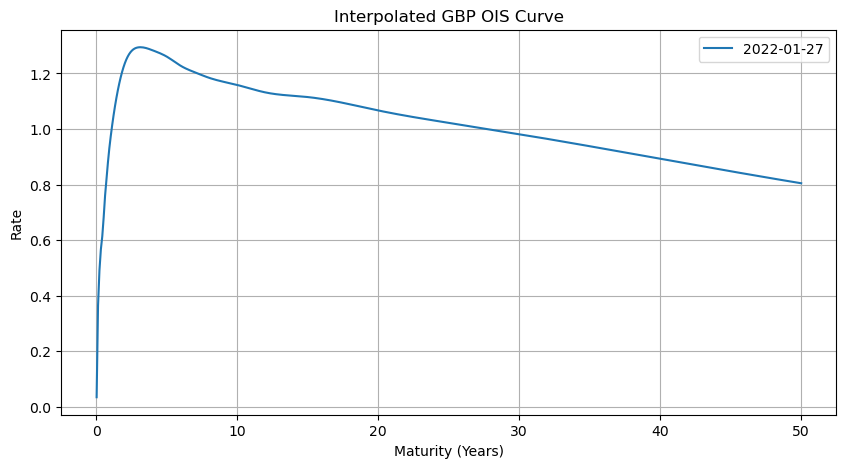

In [24]:
import matplotlib.pyplot as plt

# Choisir une date
example_date = list(ois_curves.keys())[0]
curve = ois_curves[example_date]

# Maturités à tester
x = np.linspace(0.01, 50, 500)
y = curve(x)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label=str(example_date.date()))
plt.title("Interpolated GBP OIS Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()
plt.show()


In [25]:
# question 2 : z-spreads

# zero-coupon rate

import numpy as np

# On suppose que la première colonne est 'date'
df_rates['Date'] = pd.to_datetime(df_rates['Date'])
df_zc = df_rates.copy()

# On applique la formule ZC(T) = 1 / (1 + r)^T
for col in df_rates.columns[1:]:  # skip 'date'
    T = eval(col)  # ex: "7/365" devient 0.019...
    df_zc[col] = 1 / (1 + df_rates[col])**T
df_zc.head

<bound method NDFrame.head of           Date   7 / 365  14 / 365    1 / 12    2 / 12    5 / 12    6 / 12  \
0   2022-01-27  0.999963  0.999854  0.999684  0.999279  0.997442  0.996648   
1   2022-01-28  0.999956  0.999853  0.999680  0.999273  0.997378  0.996563   
2   2022-01-31  0.999936  0.999842  0.999658  0.999217  0.997246  0.996404   
3   2022-02-01  0.999929  0.999839  0.999649  0.999207  0.997238  0.996392   
4   2022-02-02  0.999922  0.999834  0.999639  0.999186  0.997208  0.996391   
..         ...       ...       ...       ...       ...       ...       ...   
711 2024-11-19  0.999119  0.998238  0.996172  0.992368  0.981347  0.977782   
712 2024-11-20  0.999119  0.998238  0.996172  0.992368  0.981363  0.977816   
713 2024-11-21  0.999119  0.998238  0.996172  0.992379  0.981455  0.977938   
714 2024-11-22  0.999119  0.998238  0.996173  0.992377  0.981455  0.977961   
715 2024-11-25  0.999119  0.998238  0.996175  0.992376  0.981476  0.977978   

       7 / 12    8 / 12    9 / 12

In [73]:
# selection of bonds 

selected_bonds = ["GB00BL68HG94", "GB00BMGR2791", "GB00BLPK7110"]
start_date = "2022-01-27"
end_date = "2023-01-26"

df_bonds_prices = pd.read_excel("Gilts_Historical_Data_2020_2024.xlsx", sheet_name="HIST_PRICE", header=0)
df_bonds_prices["eod_date"] = pd.to_datetime(df_bonds_prices["eod_date"])
df_selected_bonds = df_bonds_prices[["eod_date"] + selected_bonds]
df_selected_bonds.set_index('eod_date', inplace=True)
df_selected_bonds = df_selected_bonds.loc[start_date:end_date]

df_charac = pd.read_excel("Gilts_Historical_Data_2020_2024.xlsx", sheet_name="STATIC", header=0)
filtered_df = df_charac[df_charac["instrument_id"].isin(selected_bonds)]
filtered_df.loc[:, "instrument_id"] = filtered_df["instrument_id"].astype(str)

# Pv prices 
from datetime import datetime
from dateutil.relativedelta import relativedelta

def compute_accrued_interest(current_date, first_coupon_date, maturity_date, coupon_rate, face_value=100):
    # Génère les dates de coupons tous les 6 mois
    coupon_dates = []
    _coupon_date = pd.to_datetime(first_coupon_date)
    maturity_date = pd.to_datetime(maturity_date)
    
    while _coupon_date <= maturity_date:
        coupon_dates.append(_coupon_date)
        _coupon_date += relativedelta(months=6)
    
    # Identifie les dates pertinentes
    current_date = pd.to_datetime(current_date)
    past_coupons = [d for d in coupon_dates if d <= current_date]
    future_coupons = [d for d in coupon_dates if d > current_date]
    
    if not past_coupons or not future_coupons:
        return 0, coupon_dates  # Pas d’intérêt couru
    
    last_coupon = past_coupons[-1]
    next_coupon = future_coupons[0]
    
    days_elapsed = (current_date - last_coupon).days
    total_days = (next_coupon - last_coupon).days
    coupon_amount = face_value * coupon_rate / 2  # semi-annuel
    accrued = coupon_amount * days_elapsed / total_days
    return accrued, coupon_dates


def compute_all_dirty_prices(df_prices, df_info):
    df_dirty = pd.DataFrame(index=df_prices.index, columns=df_prices.columns)
    coupon_dates_dict = {}  # Nouveau : stocke les dates de coupons

    for bond in df_prices.columns:
        bond_info = df_info[df_info["instrument_id"] == bond]
        maturity = bond_info["maturity_date"].iloc[0]
        coupon = bond_info["coupon"].iloc[0]
        first_coupon = bond_info["first_coupon_date"].iloc[0]

        for date in df_prices.index:
            clean = df_prices.loc[date, bond]
            accrued, coupon_dates = compute_accrued_interest(date, first_coupon, maturity, coupon)
            df_dirty.loc[date, bond] = clean + accrued

        # Stocke les coupon_dates pour ce bond
        coupon_dates_dict[bond] = coupon_dates

    return df_dirty, coupon_dates_dict



In [74]:
df_dirty_prices, coupon_dates = compute_all_dirty_prices(df_selected_bonds, filtered_df)
df_dirty_prices.head()

,GB00BL68HG94,GB00BMGR2791,GB00BLPK7110
eod_date,,,
2022-01-27,1.053918,1.044644,0.97792
2022-01-28,1.054236,1.044903,0.97788
2022-01-31,0.991996,0.981961,0.97573
2022-02-01,0.992194,0.981912,0.976071
2022-02-02,0.99308,0.983081,0.977961
